# Cryptocurrencies - Predicting daily prices
By Trang VO
https://github.com/trang-h-vo

## Data preparation

### Load data & libraries

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

In [3]:
folder_path = str(os.getcwd()) + '/'
cryptos = pd.read_csv(folder_path + 'crypto-markets.csv')
print(cryptos.shape)
cryptos.head()

(942297, 13)


,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.488567e+09,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.603769e+09,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.542813e+09,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.298955e+09,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.168517e+09,0.3881,33.32


### Substract Bitcoin prices

In [4]:
btc = cryptos[cryptos['symbol']=='BTC'].sort_values(by='date')
btc.describe()

,ranknow,open,high,low,close,volume,market,close_ratio,spread
count,2042.0,2042.000000,2042.000000,2042.000000,2042.000000,2.042000e+03,2.042000e+03,2042.000000,2042.000000
mean,1.0,2285.455421,2354.447723,2207.495544,2287.287272,1.450143e+09,3.785297e+10,0.541097,146.952179
std,0.0,3438.652272,3563.970934,3285.670083,3438.366702,3.042556e+09,5.853611e+10,0.299901,355.994292
min,1.0,68.500000,74.560000,65.530000,68.430000,0.000000e+00,7.784112e+08,0.000000,0.000000
25%,1.0,320.590000,329.070000,313.412500,321.135000,1.868702e+07,4.386274e+09,0.280050,7.245000
50%,1.0,598.015000,607.365000,587.275000,598.140000,5.814580e+07,8.154787e+09,0.559250,19.480000
75%,1.0,2607.887500,2749.390000,2536.247500,2608.680000,1.206027e+09,4.284981e+10,0.808700,117.482500
max,1.0,19475.800000,20089.000000,18974.100000,19497.400000,2.384090e+10,3.265025e+11,1.000000,4110.400000


Consolidate daily average price by averaging open, close, high & low prices:

In [5]:
btc['daily_price'] = (btc['open'] + btc['close'] + btc['high'] + btc['low']) / 4

**Plot daily prices, trading volume in one graph**

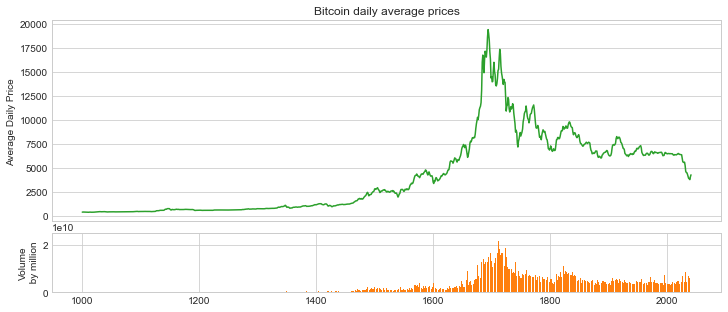

In [6]:
btc_plot = btc.iloc[1000:,[9,13]]
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,5))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
top.plot(btc_plot['daily_price'], color='tab:green')
bottom.bar(btc_plot.index, btc_plot['volume'], color='tab:orange') 
 
# set the labels
top.axes.get_xaxis().set_visible(False)
top.set_title('Bitcoin daily average prices')
top.set_ylabel('Average Daily Price')
bottom.set_ylabel('Volume\n by million')
plt.show()

**Autocorrelation**

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

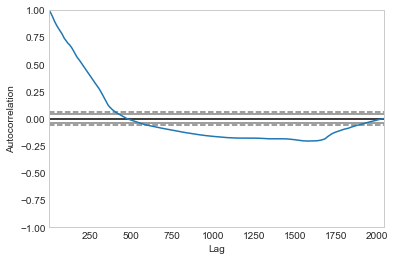

In [7]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(btc['daily_price'])

## Baseline forecasts

### Moving average
A naive forecast approach as a baseline is moving average values, where we use average values of the previous time steps as our predictions. 
- Computing moving average series for window time as 1, 10 & 30.
- Using moving average with window = 1 as our baseline forecasts.
- Set metrics to evaluate the predictions: mean_squared_error and mean_absolute_error

In [8]:
def moving_average_forecast(series, ma_range):
    ma_pred = []
    for time in range(len(series) - ma_range):
        ma_pred.append(series[time:(time+ma_range)].mean())
    return np.array(ma_pred)

btc_series = np.array(btc['daily_price'])
time = btc.index.values
split_point = 1800

ma_1 = moving_average_forecast(btc_series, 1)[(split_point-1):]
ma_10 = moving_average_forecast(btc_series, 10)[(split_point-10):]
ma_30 = moving_average_forecast(btc_series, 30)[(split_point-30):]

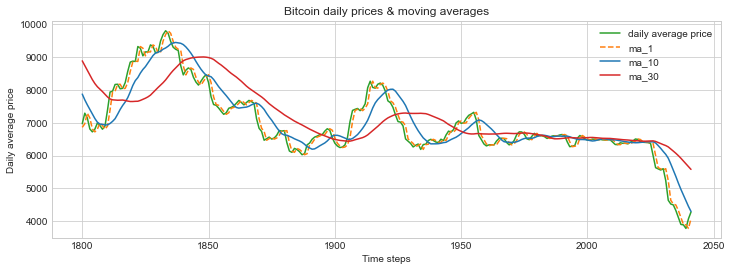

In [9]:
time_valid = time[split_point:]
y_valid = btc_series[split_point:]

plt.figure(figsize=(12,4))

plt.plot(time_valid, y_valid, color='tab:green', label='daily average price')
plt.plot(time_valid, ma_1, '--', color='tab:orange', label='ma_1')
plt.plot(time_valid, ma_10, color='tab:blue', label='ma_10')
plt.plot(time_valid, ma_30, color='tab:red', label='ma_30')

plt.xlabel('Time steps')
plt.ylabel('Daily average price')
plt.title('Bitcoin daily prices & moving averages', fontsize=12)
plt.legend()
plt.show()

### Metrics

In [10]:
from tensorflow.keras.metrics import mean_squared_error, mean_absolute_error

In [11]:
print('Naive forecast - ma_1:')
print(f'Mean squared error: {mean_squared_error(y_valid, ma_1).numpy()}')
print(f'Mean absolute error: {mean_absolute_error(y_valid, ma_1).numpy()}')

Naive forecast - ma_1:
Mean squared error: 27102.700222236566
Mean absolute error: 114.51379132231395


### Windowed datasets

Initial settings: 
- Number of lags: 10
- Train set: 1800 observations
- Validation set: 150 observations, targets start from split point, inputs start from split - window_size step
- Test set: 92 observations
- Standardize all inputs & outputs, using the mean & std of the train inputs only

In [12]:
split_point = 1800
window_size = 10

Define train, validation & test sets:

In [13]:
train_time = time[:split_point]
train_set = btc_series[:split_point]

val_window_start = split_point - (window_size)
validation_set = btc_series[val_window_start:(split_point+150)]

test_window_start = split_point + 150 - window_size
test_set = btc_series[test_window_start:]

Define a function to get inputs & outputs of each dataset:

In [14]:
def get_windowed_dataset(series, window):
    '''Separate lags as inputs & next time step as outputs'''
    inputs, outputs = [], []
    input_length = len(series) - window

    for i in range(0,input_length):
        input_sample = series[i:i+window]
        inputs.append(input_sample)

        output_sample = series[i+window]
        outputs.append(output_sample)

    return np.array(inputs), np.array(outputs)

In [15]:
train_inputs, train_targets = get_windowed_dataset(train_set, window_size)
val_inputs, val_targets = get_windowed_dataset(validation_set, window_size)
test_inputs, test_targets = get_windowed_dataset(test_set, window_size)

Normalize inputs & targets for both train & val sets, using mean & std of the train inputs only:

In [16]:
train_mean = train_inputs.mean()
train_std = train_inputs.std()

def norm(series):
    return (series - train_mean) / train_std

train_inputs_normed = norm(train_inputs)
train_targets_normed = norm(train_targets)

val_inputs_normed = norm(val_inputs)
val_targets_normed = norm(val_targets)

test_inputs_normed = norm(test_inputs)
test_targets_normed = norm(test_targets)

In [17]:
print('Train, validation & test splits:')
print('Window size: {}'.format(window_size))
print('Full train set: {}, train inputs: {}, train targets: {}'\
      .format(train_set.shape, train_inputs_normed.shape, train_targets_normed.shape))
print('Full validation set: {}, val inputs: {}, val targets: {}'\
      .format(validation_set.shape, val_inputs_normed.shape, val_targets_normed.shape))
print('Full test set: {}, test inputs: {}, test targets: {}'\
      .format(test_set.shape, test_inputs_normed.shape, test_targets_normed.shape))

Train, validation & test splits:
Window size: 10
Full train set: (1800,), train inputs: (1790, 10), train targets: (1790,)
Full validation set: (160,), val inputs: (150, 10), val targets: (150,)
Full test set: (102,), test inputs: (92, 10), test targets: (92,)


## Machine Learning

### MLP

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import callbacks
tf.random.set_seed(42)

In [19]:
n_epochs = 1000
units_mlp = 100

mlp = Sequential()

mlp.add(Dense(units_mlp, input_shape=(window_size,), activation='relu'))
mlp.add(Dense(units_mlp, activation='relu'))

mlp.add(Dense(1))

optimizer_mlp = tf.keras.optimizers.Adam(lr=0.0001)

mlp.compile(loss='mean_squared_error',
              optimizer= optimizer_mlp, metrics=['mae'])

callbacks_mlp = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=20,
                                         restore_best_weights=True)

history_mlp = mlp.fit(train_inputs_normed, train_targets_normed,
                      epochs=n_epochs, 
                      callbacks=callbacks_mlp,
                      validation_data=(val_inputs_normed, val_targets_normed),
                      batch_size=4, verbose=0)

MLP {units_mlp} x {units_mlp} units:


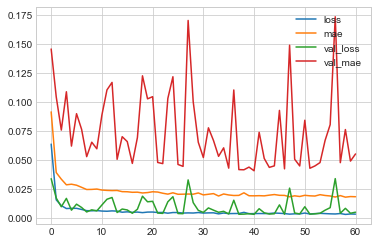

In [20]:
print('MLP {units_mlp} x {units_mlp} units:')
pd.DataFrame(history_mlp.history).plot(figsize=(6,4))
plt.show()

Get scores on the validation set:

In [21]:
mlp_100_100 = mlp.evaluate(val_inputs_normed, val_targets_normed)

5/5 [==============================] - 0s 2ms/step - loss: 0.0029 - mae: 0.0404


### Simple RNNs

**Data prep for RNN models:**

Expand the inputs for one more dimension.

In [22]:
def expand_dim(series):
    return series.reshape(series.shape[0], series.shape[1], 1)

In [23]:
train_inputs_rnn = expand_dim(train_inputs)
val_inputs_rnn = expand_dim(val_inputs)
test_inputs_rnn = expand_dim(test_inputs)

Normalize inputs for all train, validation & test sets, using mean & std of the train inputs only:

In [24]:
train_inputs_rnn_normed = norm(train_inputs_rnn)
val_inputs_rnn_normed = norm(val_inputs_rnn)
test_inputs_rnn_normed = norm(test_inputs_rnn)

In [25]:
print('RNN models: Train, validation & test splits:')
print('Window size: {}'.format(window_size))
print('Full train set: {}, train inputs: {}, train targets: {}'\
      .format(train_set.shape, train_inputs_rnn_normed.shape, train_targets_normed.shape))
print('Full validation set: {}, val inputs: {}, val targets: {}'\
      .format(validation_set.shape, val_inputs_rnn_normed.shape, val_targets_normed.shape))
print('Full test set: {}, test inputs: {}, test targets: {}'\
      .format(test_set.shape, test_inputs_rnn_normed.shape, test_targets_normed.shape))

RNN models: Train, validation & test splits:
Window size: 10
Full train set: (1800,), train inputs: (1790, 10, 1), train targets: (1790,)
Full validation set: (160,), val inputs: (150, 10, 1), val targets: (150,)
Full test set: (102,), test inputs: (92, 10, 1), test targets: (92,)


**Simple RNN**

In [26]:
from tensorflow.keras.layers import SimpleRNN, Activation

In [27]:
n_epochs = 500

simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(units=50, return_sequences=True, input_shape=[None,1]))
simple_rnn.add(Activation('tanh'))

simple_rnn.add(SimpleRNN(50))

simple_rnn.add(Dense(1, activation='linear'))

optimizer_rnn = tf.keras.optimizers.Adam(lr=0.0001)

simple_rnn.compile(loss='mse',
              optimizer=optimizer_rnn, metrics=['mae'])

callbacks_rnn = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=20,
                                         restore_best_weights=True)

history_rnn = simple_rnn.fit(train_inputs_rnn_normed, train_targets_normed,
                             epochs=n_epochs,
                             validation_data = (val_inputs_rnn_normed, val_targets_normed),
                             callbacks=callbacks_rnn,
                             batch_size=8, verbose=0)

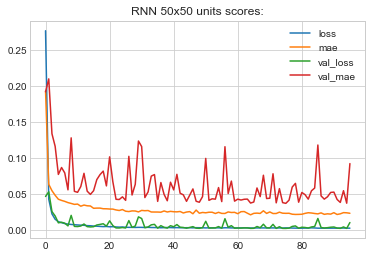

In [28]:
pd.DataFrame(history_rnn.history).plot()
plt.title('RNN 50x50 units scores:')
plt.legend()
plt.show()

Get scores on the validation set:

In [29]:
rnn_50_50 = simple_rnn.evaluate(val_inputs_rnn_normed, val_targets_normed)

5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - mae: 0.0373


### LSTM

In [30]:
from tensorflow.keras.layers import LSTM, GRU

In [31]:
epochs_lstm = 500

lstm = Sequential()

lstm.add(LSTM(30, return_sequences=True, input_shape=(window_size,1)))
lstm.add(Activation('tanh'))

lstm.add(LSTM(30))

lstm.add(Dense(1))

optimizer_lstm = tf.keras.optimizers.Adam(lr=0.0001)

lstm.compile(loss= 'mse',
             optimizer=optimizer_lstm,
             metrics=['mae'])

callbacks_lstm = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=20,
                                         restore_best_weights=True)

history_lstm = lstm.fit(train_inputs_rnn_normed, train_targets_normed,
                        epochs=epochs_lstm,
                        batch_size=8,
                        callbacks=callbacks_lstm,
                        validation_data = (val_inputs_rnn_normed, val_targets_normed),
                        verbose=0)

LSTM scores:


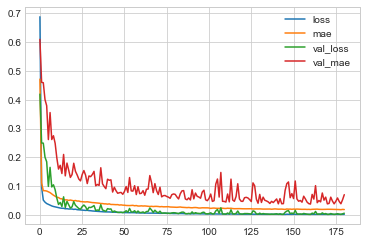

In [32]:
print('LSTM scores:')
pd.DataFrame(history_lstm.history).plot()
plt.legend()
plt.show()

In [33]:
lstm_30_30 = lstm.evaluate(val_inputs_rnn_normed, val_targets_normed)

5/5 [==============================] - 0s 7ms/step - loss: 0.0026 - mae: 0.0385


### GRU

**GRU with 2 hidden layers of 30 units each**

In [34]:
epochs_gru_30 = 500

gru_30 = Sequential()

gru_30.add(GRU(30, return_sequences=True, input_shape=(window_size,1)))
gru_30.add(Activation('tanh'))

gru_30.add(GRU(30, return_sequences=False))

gru_30.add(Dense(1))

optimizer_gru_30 = tf.keras.optimizers.Adam(lr=0.0001)

gru_30.compile(loss= 'mse',
             optimizer=optimizer_gru_30,
             metrics=['mae']
    )

callbacks_gru_30 = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=20,
                                         restore_best_weights=True)

history_gru_30 = gru_30.fit(train_inputs_rnn_normed, train_targets_normed,
                        epochs=epochs_gru_30,
                        batch_size=2,
                        callbacks=callbacks_gru_30, 
                        validation_data = (val_inputs_rnn_normed, val_targets_normed),
                          verbose=0)

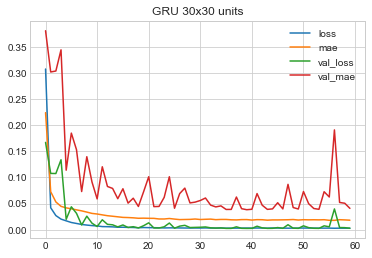

In [35]:
pd.DataFrame(history_gru_30.history).plot()
plt.title('GRU 30x30 units')
plt.legend()
plt.show()

In [36]:
gru_30_30 = gru_30.evaluate(val_inputs_rnn_normed, val_targets_normed)

5/5 [==============================] - 2s 16ms/step - loss: 0.0025 - mae: 0.0384


**GRU with 3 hidden layers of 10 units each**

In [37]:
epochs_gru_10 = 500

gru_10 = Sequential()

gru_10.add(GRU(10, return_sequences=True, input_shape=(window_size,1)))
gru_10.add(Activation('tanh'))

gru_10.add(GRU(10, return_sequences=True))
gru_10.add(GRU(10))

gru_10.add(Dense(1))

optimizer_gru_10 = tf.keras.optimizers.Adam(lr=0.0001)

gru_10.compile(loss= 'mse',
             optimizer=optimizer_gru_10,
             metrics=['mae'])

callbacks_gru_10 = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=20,
                                         restore_best_weights=True)

history_gru_10 = gru_10.fit(train_inputs_rnn_normed, train_targets_normed,
                        epochs=epochs_gru_10,
                        batch_size=8,
                        callbacks=callbacks_gru_10,
                        validation_data = (val_inputs_rnn_normed, val_targets_normed), verbose=0)

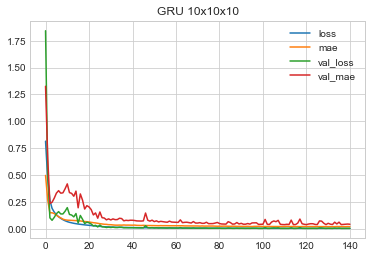

In [38]:
pd.DataFrame(history_gru_10.history).plot()
plt.title('GRU 10x10x10')
plt.legend()
plt.show()

In [39]:
gru_10_10_10 = gru_10.evaluate(val_inputs_rnn_normed, val_targets_normed)

5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0379


### Model selection

In [40]:
all_scores = pd.DataFrame({'mlp_100_100': mlp_100_100,
                           'rnn_50_50': rnn_50_50,
                          'lstm_30_30': lstm_30_30,
                          'gru_30_30': gru_30_30,
                          'gru_10_10_10': gru_10_10_10},
                          index=['mse','mae'])
print('Compare all models predictions on the validation set:')
all_scores

Compare all models predictions on the validation set:


,mlp_100_100,rnn_50_50,lstm_30_30,gru_30_30,gru_10_10_10
mse,0.002859,0.002429,0.002648,0.002544,0.002505
mae,0.040442,0.037288,0.038457,0.038352,0.037871


### Ensemble predictions

In [43]:
# mlp predictions
preds_mlp_normed = mlp.predict(test_inputs_normed).reshape(-1)

# RNNs predictions
preds_rnn_normed = simple_rnn.predict(test_inputs_rnn_normed).reshape(-1)
preds_lstm_normed = lstm.predict(test_inputs_rnn_normed).reshape(-1)
preds_gru_10_normed = gru_10.predict(test_inputs_rnn_normed).reshape(-1)
preds_gru_30_normed = gru_30.predict(test_inputs_rnn_normed).reshape(-1)

In [44]:
ensemble_preds_normed = (preds_mlp_normed + preds_rnn_normed + preds_lstm_normed \
                         + preds_gru_10_normed + preds_gru_30_normed) / 5

# inverse transform
ensemble_preds = (ensemble_preds_normed * train_std) + train_mean

In [45]:
print('Ensemble scores:')

mse_normed = mean_squared_error(test_targets_normed, ensemble_preds_normed).numpy()
mae_normed = mean_absolute_error(test_targets_normed, ensemble_preds_normed).numpy()

print(f'Mean squared error normalized: {mse_normed}')
print(f'Mean absolute error normalized: {mae_normed}')
print(f'Mean squared error: {mean_squared_error(test_targets, ensemble_preds).numpy()}')
print(f'Mean absolute error: {mean_absolute_error(test_targets, ensemble_preds).numpy()}')

Ensemble scores:
Mean squared error normalized: 0.0014749109977856278
Mean absolute error normalized: 0.02399473637342453
Mean squared error: 14403.0947265625
Mean absolute error: 74.98269653320312


Plot the true values & predicted values

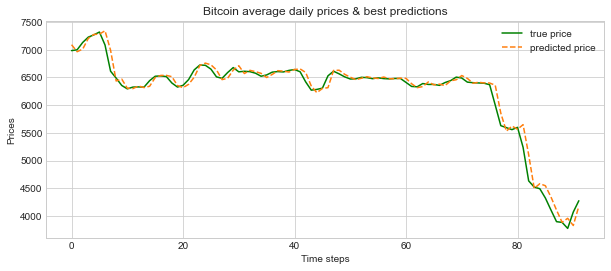

In [46]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,4))

plt.plot(test_targets, 'g', label='true price') # time_valid, 
plt.plot(ensemble_preds, c='tab:orange', linestyle='--', label='predicted price')

plt.xlabel('Time steps')
plt.ylabel('Prices')

plt.legend()
plt.title('Bitcoin average daily prices & best predictions', fontsize=12)
plt.show()

**Future improvements:**

- Experiement with different lagged values.
- Add features such as day-of-week to capture weekly seasonality (if any), lagged daily trading volume and/or spread.
- Hyperparameter tuning using Keras Tuners, such as RandomSearch or Hyperband. Important hyperparameters to tune include: number of layers, number of neurons in each layer, activation function in each layer, optimizer, learning rate, etc.
- Train models multiple times using different random seeds to see the performance variance.